# Evaluation

The goal of this lab is to introduce you to techniques for evaluating your trained models. The motivation is to be able to select the model that has the best (expected) out-of-sample prediction and to assess the quality of the model.

## 1. Model Selection in a holdout setting

We will work with the <a href="https://en.wikipedia.org/wiki/Iris_flower_data_set">Iris</a> data set. The iris data set consists out of $4$ features (sepal length, sepal width, petal length, petal width) of three kinds of flowers in the iris family: iris setosa, iris versicolor, iris virginica. Our version of the data set has 150 data points with 50 for each class.

In [295]:
# Load the data
%matplotlib inline

import matplotlib.pyplot as plt
from sklearn.datasets import load_iris

iris = load_iris()
print('Loaded {} data points'.format(len(iris.data)))

X, y = iris.data, iris.target

print('Class labels: {}'.format(list(zip(range(3), iris.target_names))))

Loaded 150 data points
Class labels: [(0, 'setosa'), (1, 'versicolor'), (2, 'virginica')]


We try to classify the iris versicolor with the help of the first two features.

In [296]:
import numpy as np

X_versi = X[:, :2] 
y_versi = np.zeros(len(y))
y_versi[y == 1] = 1

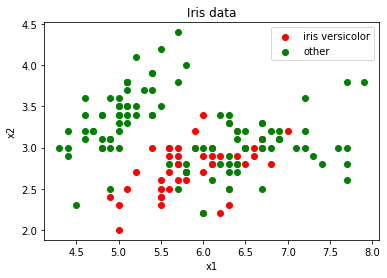

In [297]:
# plot iris data with two features
plt.scatter(X_versi[y_versi == 1, 0], X_versi[y_versi == 1, 1], c='red', label='iris versicolor')
plt.scatter(X_versi[y_versi == 0, 0], X_versi[y_versi == 0, 1], c='green', label='other')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title('Iris data')
plt.legend()
plt.show()

We split the data into a train and test (holdout) set with a split ratio of 75% to 25%.

In [298]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_versi, y_versi, test_size=0.25, random_state=3)

The following function is a little visualization helper that draws the values of the decision function on a heat map given a matplotlib axe.

In [299]:
def show_decision_function(clf, ax):
    xx, yy = np.meshgrid(np.linspace(4.5, 8, 200), np.linspace(1.5, 4.0, 200))
    try:
        Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
    except AttributeError:
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()])

        

    Z = Z.reshape(xx.shape)
    ax.pcolormesh(xx, yy, Z, cmap=plt.cm.jet)
    ax.set_xlim(4.5, 8)
    ax.set_ylim(1.5, 4.0)
    ax.set_xticks(())
    ax.set_yticks(())
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=100)

We now train a SVM classifier on the training data and plot its decision boundary.

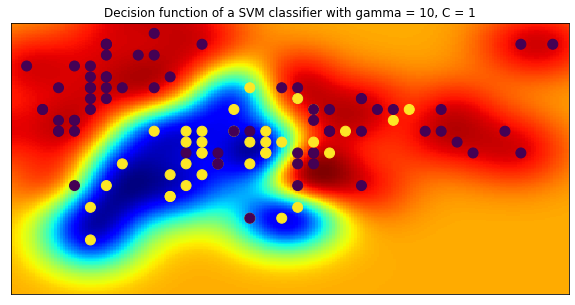

In [300]:
from sklearn.svm import SVC

clf_svm = SVC(gamma=10, C=1, probability=True)
clf_svm.fit(X_train, y_train)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
show_decision_function(clf_svm, ax)
ax.set_title('Decision function of a SVM classifier with gamma = 10, C = 1');

#### Exercise 1.1 (Performance measures)
Classify the test data and evaluate the classification performance of the trained model 'clf_svm' using the scikit-learn metrics package. Compare various metrics (classification accuracy, precision, recall, f-score), interpret their values and argue which of them might be the most meaningful to report.

In [301]:
from sklearn import metrics

####################
# INSERT CODE HERE #
####################

def accuracy(y_pred,y_true):
    misses = 0 #variable to count the misses
    for i in range(0,y_pred.size): #loop through prediction
        if y_pred[i] != y_true[i]: #check if prediction was wrong
            misses += 1 #prediction was wrong we add one miss
    return (y_pred.size - misses) / y_pred.size #calculate accuracy and return it

def precision(y_pred,y_true):
    true_positives = 0 #variable to count the true positives
    false_positives = 0 #variable to count the false positives
    for i in range(0,y_pred.size): #loop through prediction
        if y_pred[i] == 1: #check if prediction is positive
            if y_true[i] == 1:
                true_positives += 1 #prediction was right
            else:
                false_positives += 1 #prediction was wrong
    return true_positives / (true_positives + false_positives) #calculate precision and return it

def recall(y_pred,y_true):
    true_positives = 0 #variable to count the true positives
    false_negatives = 0 #variable to count the false negatives
    for i in range(0,y_pred.size): #loop through prediction
        if y_pred[i] == 1 and y_true[i] == 1: #check for true positive
            true_positives += 1
            continue 
        if y_pred[i] == 0 and y_true[i] == 1: #check for false negative
            false_negatives += 1
    return true_positives / (true_positives + false_negatives) #calculate recall and return it

def f_score(y_pred,y_true):
    prec = precision(y_pred,y_true) #get precision
    rec = recall(y_pred,y_true) #get recall 
    return 2 * ((prec * rec) / (prec + rec)) #calculate f-score and return it

prediction = clf_svm.predict(X_test) #make prediction with trained model

"""
All values are not bad, but not great either, which means the model is
probably not the best fit. In our case we do not have a bias towards
true positives in context to false positives and true negatives. Thats
why the accuracy is for our model most important.
"""

print("Accuracy of the model:",accuracy(y_true=y_test,y_pred=prediction)) #display accuracy of the model
print("Precision of the model:",precision(y_true=y_test,y_pred=prediction)) #display precision of the model
print("Recall of the model:",recall(y_true=y_test,y_pred=prediction)) #display recall of the model
print("F-score of the model:",f_score(y_true=y_test,y_pred=prediction)) #display f-score of the model
    

Accuracy of the model: 0.7631578947368421
Precision of the model: 0.6666666666666666
Recall of the model: 0.5
F-score of the model: 0.5714285714285715


#### Exercise 1.2 (ROC curve)

To further evaluate the model, we want to plot a ROC (Receiver operating characteristic) curve and look at the AUC (area under the curve) value. Therefore, we provide a function "plot_roc_curves" that accepts increasing false positive rates (fprs) and true positive rates (tprs) and plots the curve for you. 

Please calculate the false and true positive rates of the classifier 'clf_svm' on the test data 'X_test' and draw the ROC curve by executing the function 'plot_roc_curves'. What does the ROC and AUC tell us about the classifier's performance?

In [302]:
# helper to plot ROC curves
def plot_roc_curves(fprs, tprs):    
    fig = plt.figure(figsize=(20,10))
    
    for fpr, tpr in zip(fprs, tprs):
        plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % metrics.auc(fpr, tpr))
    
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

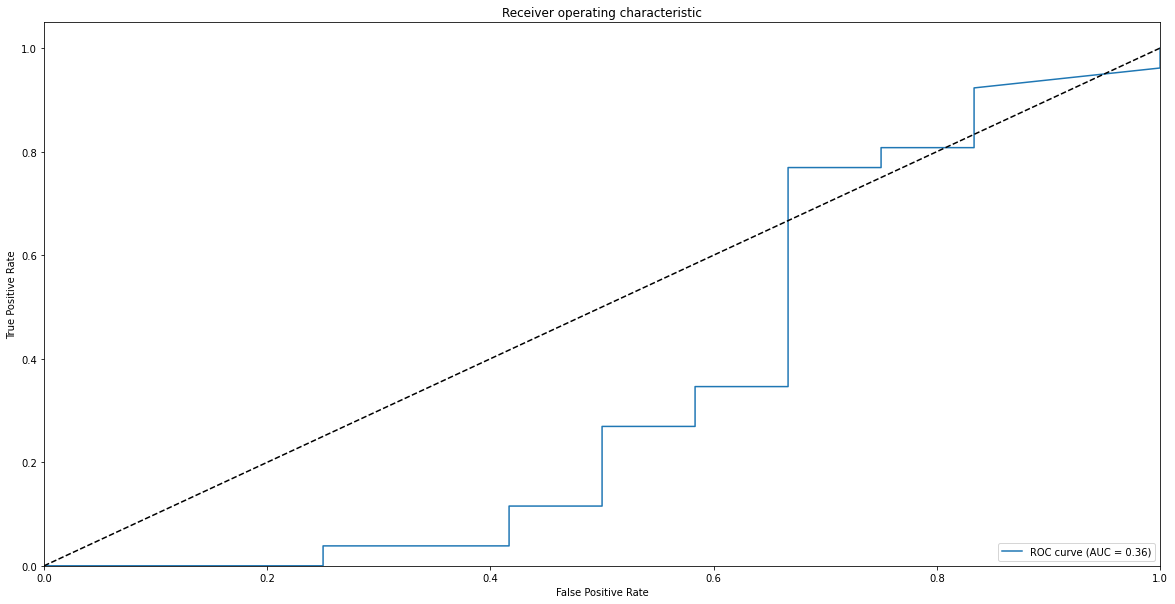

In [303]:
####################
# INSERT CODE HERE #
####################

def getRates(y_pred,y_true):
    fp = 0 #count of false positives
    tp = 0 #count of true positives
    fn = 0 #count of false negatives
    tn = 0 #count of true negatives
    for i in range(0,y_pred.size): #loop throug predictions
        if y_pred[i] == 1: #check if prediction is positive
            if y_true[i] == 1: #check if true label is positive
                tp += 1
            else:
                fp += 1
        else:
            if y_true[i] == 1: #chekc if true label is positive
                fn += 1
            else:
                tn += 1
    fpr = fp / (fp + tn) #calculate false positive rate
    tpr = tp / (tp + fn) #calculate true positive rate
    return fpr, tpr #return rates 

fprs, tprs = [], [] #lists to collect rates
y_score = clf_svm.decision_function(X_test) 
thresholds = [1 + max(y_score)] + sorted(set(y_score),reverse=True) #compute thresholds
for threshold in thresholds: #loop through thresholds
    y_pred = np.where(y_score >= threshold, 1, 0) #1 if y_score >= threshold, else 0 (making the decision)
    fpr, tpr = getRates(y_pred, y_test) #get rates with new prediction (performance of the threshold)
    tprs.append(fpr) #add rate to list
    fprs.append(tpr) #add rate to list

"""
With the ROC and AUC we can determine the best performing
threshold to make a prediction of the vlues given by the
model. In our case we can see that the thresholds that are
giving us high true positives rates are also giving us very
high false positives rates, which is not ideal and tells us
that we probably switch or at least tune the model.
"""
# plot the curve
plot_roc_curves([fprs], [tprs])

#### Exercise 1.3 (Model comparison)

Train four more SVM models on the training data by varying the regularization parameter $C$ (the gamma parameter can be set to 10 again). Put the models into a list 'clfs' using the append method. You can add a name to each classifier by setting clf.name = "some description" to keep track of the configuration.

In [304]:
clfs = []

####################
# INSERT CODE HERE #
####################

#first model C=10
clfs.append(SVC(gamma=10, C=10, probability=True))
clfs[0].fit(X_train, y_train)
clfs[0].name = "model 1"

#second model C=25
clfs.append(SVC(gamma=10, C=25, probability=True))
clfs[1].fit(X_train, y_train)
clfs[1].name = "model 2"

#third model C=100
clfs.append(SVC(gamma=10, C=100, probability=True))
clfs[2].fit(X_train, y_train)
clfs[2].name = "model 3"

#fourth model C=1000
clfs.append(SVC(gamma=10, C=1000, probability=True))
clfs[3].fit(X_train, y_train)
clfs[3].name = "model 4"


Let's have a look at the decision functions of the four classifiers...

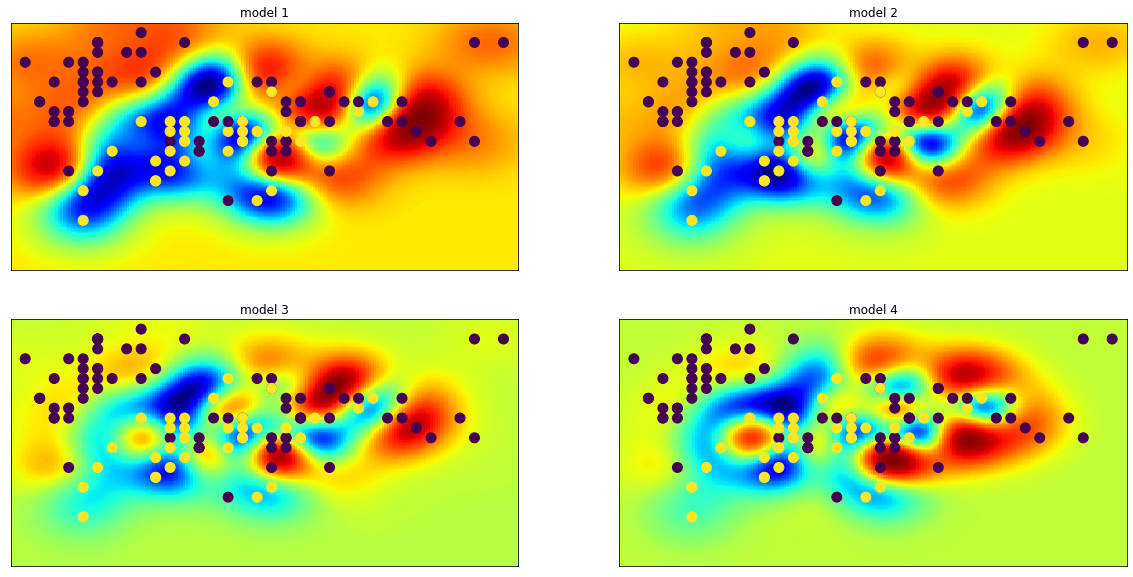

In [305]:
# visualize the decision functions of the four different classifiers
fig, axes = plt.subplots(2, 2, figsize=(20, 10))

for clf, ax in zip(clfs, axes.ravel()):
    show_decision_function(clf, ax)
    ax.set_title(clf.name)

... and draw the ROC curves.

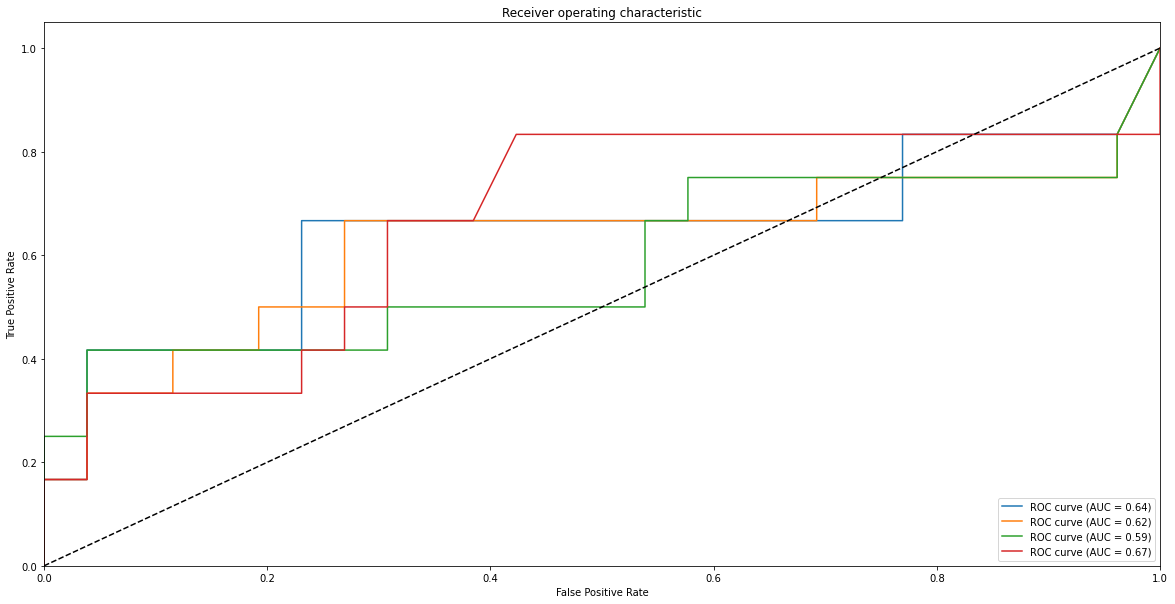

In [306]:
# draw the roc curves:

fprs, tprs = [], []

for clf in clfs:
    y_score = clf.decision_function(X_test)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_score, pos_label=1)
    fprs.append(fpr)
    tprs.append(tpr)
    
plot_roc_curves(fprs, tprs)

## 2. Hyperparameter Tuning

Many models have hyperparameters, parameters that can't directly be estimated from the data. They have to be manually tuned by the practioner, because there is no analytical formula available to calculate an appropriate value. One example is the regularization parameter $C$ in SVMs.

#### Exercise 2.1 (Nested cross-validation)

Train a SVM classifier for the detection of iris versicolor again, but this time with a proper tuning of the regularization parameter $C$ (you may set the gamma parameter to 10 again). Select a reasonable range of parameter values for $C$ and implement a nested cross-validation (as shown on the slides) by yourself. 

You can use the following helper function that creates a list of masks. Each mask can be used as an index set to select the test samples. The function accepts the number of samples *num_samples* in the dataset and the desired number of folds *k* as input parameters. Since the data is sorted by the labels the k-fold CV will likely have trouble with class imbalances in some cases. So you should randomly shuffle the data before applying the masks.

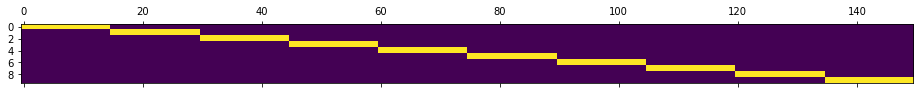

In [307]:
# helper function to create k-fold train-test-splits
def create_kfold_mask(num_samples, k):
    masks = []
    fold_size = num_samples / k
    
    for i in range(k):
        mask = np.zeros(num_samples, dtype=bool)
        mask[i*int(fold_size):(i+1)*int(fold_size)] = True
        masks.append(mask)
        
    return masks

# visualization of the splits created by 'create_kfold_mask'
masks = create_kfold_mask(150, 10)
plt.matshow(masks)
plt.show()

Average difference of 0.007581 with std. dev. of 0.007833.


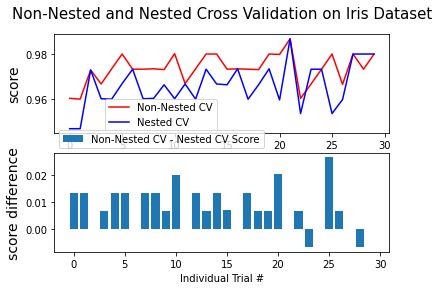

In [308]:
####################
# INSERT CODE HERE #
####################
# Set up possible values of parameters to optimize over
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score


# Number of random trials
NUM_TRIALS = 30

p_grid = {"C": [1, 10, 100], "gamma": [0.01, 0.1]}

# We will use a Support Vector Classifier with "rbf" kernel
svm = SVC(kernel="rbf")

# Arrays to store scores
non_nested_scores = np.zeros(NUM_TRIALS)
nested_scores = np.zeros(NUM_TRIALS)

# Loop for each trial
for i in range(NUM_TRIALS):

    # Choose cross-validation techniques for the inner and outer loops,
    # independently of the dataset.
    # E.g "GroupKFold", "LeaveOneOut", "LeaveOneGroupOut", etc.
    inner_cv = KFold(n_splits=4, shuffle=True, random_state=i)
    outer_cv = KFold(n_splits=4, shuffle=True, random_state=i)

    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=outer_cv)
    clf.fit(X, y)
    non_nested_scores[i] = clf.best_score_

    # Nested CV with parameter optimization
    clf = GridSearchCV(estimator=svm, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=X, y=y, cv=outer_cv)
    nested_scores[i] = nested_score.mean()

score_difference = non_nested_scores - nested_scores

print(
    "Average difference of {:6f} with std. dev. of {:6f}.".format(
        score_difference.mean(), score_difference.std()
    )
)

# Plot scores on each trial for nested and non-nested CV
plt.figure()
plt.subplot(211)
(non_nested_scores_line,) = plt.plot(non_nested_scores, color="r")
(nested_line,) = plt.plot(nested_scores, color="b")
plt.ylabel("score", fontsize="14")
plt.legend(
    [non_nested_scores_line, nested_line],
    ["Non-Nested CV", "Nested CV"],
    bbox_to_anchor=(0, 0.4, 0.5, 0),
)
plt.title(
    "Non-Nested and Nested Cross Validation on Iris Dataset",
    x=0.5,
    y=1.1,
    fontsize="15",
)

# Plot bar chart of the difference.
plt.subplot(212)
difference_plot = plt.bar(range(NUM_TRIALS), score_difference)
plt.xlabel("Individual Trial #")
plt.legend(
    [difference_plot],
    ["Non-Nested CV - Nested CV Score"],
    bbox_to_anchor=(0, 1, 0.8, 0),
)
plt.ylabel("score difference", fontsize="14")

plt.show()
